## Importing Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from wordcloud import WordCloud
from surprise import KNNBasic


import warnings; warnings.simplefilter('ignore')

In [2]:
# membaca dataset dari file CSV
anime_info_df = pd.read_csv('datasets/anime.csv')
anime_desc_df = pd.read_csv('datasets/synopsis.csv')
rating_df = pd.read_csv('datasets/rating.csv')
user_df = pd.read_csv('datasets/users.csv')

In [3]:
anime_info_df.head(5)

,MAL_ID,Name,English_name,Japanese_name,Score,Type,Episodes,Aired,Premiered,Status,...,Score_1,Score_2,Score_3,Score_4,Score_5,Score_6,Score_7,Score_8,Score_9,Score_10
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,TV,26.0,"Apr 3, 1998 to Apr 24, 1999",spring 1998,Finished Airing,...,2304,1128,2017,5024,13706,32556,97619,204868,273401,335670
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,Movie,1.0,"Sep 1, 2001",NaN,Finished Airing,...,455,148,301,770,2553,7917,30890,67993,64569,40659
2,6,Trigun,Trigun,トライガン,8.22,TV,26.0,"Apr 1, 1998 to Sep 30, 1998",spring 1998,Finished Airing,...,645,415,925,2560,7686,20453,65951,114649,96382,64769
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.24,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",summer 2002,Finished Airing,...,176,196,412,1233,3319,6628,13188,11106,5210,2748
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.93,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",fall 2004,Finished Airing,...,57,52,95,288,718,1208,1884,1326,808,407


In [4]:
#Menggabungkan dataset berdasarkan 'MAL_ID'
anime_df = pd.merge(anime_desc_df,anime_info_df[['MAL_ID','Type','Popularity','Members','Favorites']],on='MAL_ID')
anime_df.head(10)

,MAL_ID,Name,Score,Genres,synopsis,Rank,Type,Popularity,Members,Favorites
0,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",46.0,TV,43,1871594,82686
1,5,Cowboy Bebop: Tengoku no Tobira,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",198.0,Movie,619,379634,1591
2,6,Trigun,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",344.0,TV,253,765871,16069
3,7,Witch Hunter Robin,7.24,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,3022.0,TV,1862,117272,649
4,8,Bouken Ou Beet,6.93,"Action, Adventure, Fantasy",It is the dark century and the people are suff...,4506.0,TV,5350,15774,15
5,15,Eyeshield 21,7.91,Sports,"Shy, reserved, and small-statured, Deimon High...",767.0,TV,1305,184244,2059
6,16,Hachimitsu to Clover,7.99,"Comedy, Drama, Romance","Yuuta Takemoto, a sophomore at an arts college...",658.0,TV,909,269365,4204
7,17,Hungry Heart: Wild Striker,7.54,"Comedy, Slice of Life, Sports",As the younger brother of Japanese soccer star...,1731.0,TV,4413,25320,245
8,18,Initial D Fourth Stage,8.17,"Action, Drama",Takumi Fujiwara finally joins Ryousuke and Kei...,425.0,TV,1271,189423,1327
9,19,Monster,8.88,"Drama, Mystery, Suspense","Dr. Kenzou Tenma, an elite neurosurgeon recent...",23.0,TV,131,1125112,53055


In [5]:
#Menampilkan informasi dari dataset gabungan
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MAL_ID      177 non-null    int64  
 1   Name        177 non-null    object 
 2   Score       177 non-null    float64
 3   Genres      177 non-null    object 
 4   synopsis    177 non-null    object 
 5   Rank        176 non-null    float64
 6   Type        177 non-null    object 
 7   Popularity  177 non-null    int64  
 8   Members     177 non-null    int64  
 9   Favorites   177 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 14.0+ KB


In [6]:
#Menampilkan statistik deskriptif untuk kolom "Score"
anime_df["Score"].describe()

count    177.000000
mean       7.361469
std        0.656715
min        4.810000
25%        6.920000
50%        7.370000
75%        7.760000
max        8.880000
Name: Score, dtype: float64

In [7]:
#Menghapus baris dengan nilai "unknown" pada Score
anime_df = anime_df[(anime_df["Score"] != "unknown")] 

#Menampilkan jumlah baris dan kolom setelah pembersihan
anime_df.shape

(177, 10)

## Content  Filtering

In [8]:
# Now fill NaN values with empty string
anime_df['synopsis'] = anime_df['synopsis'].fillna('')
# Print some samples of the synopsis column
anime_df['synopsis'].head()


0    Crime is timeless. By the year 2071, humanity ...
1    Another day, another bounty—such is the life o...
2    Vash the Stampede is the man with a $$60,000,0...
3    Robin Sena is a powerful craft user drafted in...
4    It is the dark century and the people are suff...
Name: synopsis, dtype: object

In [9]:
# Initialize TfidfVectorizer with an appropriate min_df value
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1, stop_words='english')

# Fit and transform the synopsis data
tfidf_matrix = tfidf.fit_transform(anime_df['synopsis'])

# Check the shape of the tfidf_matrix
tfidf_matrix.shape


(177, 16972)

In [10]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(177, 177)

In [11]:
anime_df = anime_df.reset_index()
titles = anime_df['Name']
indices = pd.Series(anime_df.index, index=anime_df['Name'])

In [12]:
# Fungsi untuk menghitung sparsity data
def calculate_data_sparsity(df, user_col, item_col, rating_col):
    user_item_matrix = df.pivot_table(index=user_col, columns=item_col, values=rating_col).fillna(0)
    total_elements = user_item_matrix.size
    non_zero_elements = np.count_nonzero(user_item_matrix)
    sparsity = 1 - (non_zero_elements / total_elements)
    return sparsity

# Menampilkan sparsity data
sparsity = calculate_data_sparsity(anime_df, 'MAL_ID', 'Name', 'Score')
print(f'Data Sparsity: {sparsity * 100:.2f}%')


Data Sparsity: 99.44%


In [13]:
# Fungsi rekomendasi berbasis konten
def content_recommendations(title):
    idx = indices[title]
    #Menghitung cosine similarity untuk semua anime
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    #menghitung index
    anime_indices = [i[0] for i in sim_scores]
    
    anime_lst = anime_df.iloc[anime_indices][['Name', 'Members', 'Score']]
    # Menghitung nilai rata-rata dan kuantil untuk normalisasi
    favorite_count = anime_lst[anime_lst['Members'].notnull()]['Members'].astype('int')
    score_avg = anime_lst[anime_lst['Score'].notnull()]['Score'].astype('float')
    C = score_avg.mean()
    m = favorite_count.quantile(0.60)
    # Memfilter anime yang memenuhi syarat untuk dihitung skor tertimbangnya
    qualified = anime_lst[(anime_lst['Members'] >= m) & (anime_lst['Members'].notnull()) & (anime_lst['Score'].notnull())]
    qualified['Members'] = qualified['Members'].astype('int')
    qualified['Score'] = qualified['Score'].astype('float')
    # menghitung WR
    def weighted_rating(x):
        v = x['Members']
        R = x['Score']
        return (v / (v + m) * R) + (m / (m + v) * C)
    
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    
    # Perhitungan metrik evaluasi
    actual_scores = qualified['Score'].values
    predicted_scores = qualified['wr'].values
    rmse_content = np.sqrt(np.mean((predicted_scores - actual_scores) ** 2))
    mae = mean_absolute_error(actual_scores, predicted_scores)
    r2 = r2_score(actual_scores, predicted_scores)
    print(f'RMSE Content-Based: {rmse_content}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    
    # Menampilkan grafik hasil rekomendasi
    plt.figure(figsize=(8, 6))
    plt.barh(qualified['Name'], qualified['Score'], color='violet')
    plt.xlabel('Score')
    plt.ylabel('Anime')
    plt.title('Top 10 Anime Recommendations')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()
    
    return qualified


RMSE Content-Based: 0.20754025577556645
MAE: 0.1769354340713596
R-squared: 0.8387384583774334


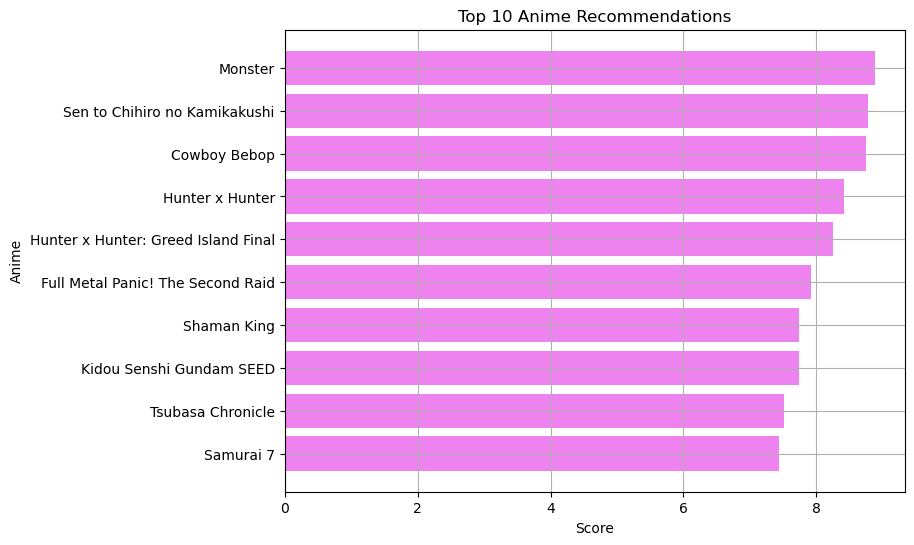

,Name,Members,Score,wr
9,Monster,1125112,8.88,8.714592
176,Sen to Chihiro no Kamikakushi,1859771,8.77,8.672782
0,Cowboy Bebop,1871594,8.75,8.654625
115,Hunter x Hunter,593740,8.41,8.205265
118,Hunter x Hunter: Greed Island Final,145956,8.25,7.783411
53,Full Metal Panic! The Second Raid,261873,7.92,7.700207
132,Shaman King,367314,7.74,7.613288
72,Kidou Senshi Gundam SEED,172055,7.74,7.530478
154,Tsubasa Chronicle,229423,7.51,7.416065
144,Samurai 7,132161,7.43,7.339933


In [14]:
content_recommendations('One Piece').head(10)

## Collaborative Filtering

In [15]:
#Menggabungkan dataset berdasarkan 'user_id'
ratingfull_df = pd.merge(user_df,rating_df[['user_id','anime_id', 'rating']],on='user_id')
ratingfull_df.head(5)

,user_id,username,url,anime_id,rating
0,1,Xinil,https://myanimelist.net/profile/Xinil,20,-1
1,1,Xinil,https://myanimelist.net/profile/Xinil,24,-1
2,1,Xinil,https://myanimelist.net/profile/Xinil,79,-1
3,1,Xinil,https://myanimelist.net/profile/Xinil,226,-1
4,1,Xinil,https://myanimelist.net/profile/Xinil,241,-1


In [16]:
# ratingfull_df['rating'] = rating_df['rating'].apply(lambda x: 1 if x < 0 else x)
ratingfull_df['rating'].value_counts()

ratingfull_df = rating_df[(rating_df["rating"] != -1)] 

In [17]:
ratingfull_df.head(5)

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [18]:
reader = Reader()
rating_data = Dataset.load_from_df(ratingfull_df, reader)
svd = SVD()

In [19]:
trainset = rating_data.build_full_trainset()

In [20]:
svd.fit(trainset)

In [21]:
svd.predict(1, 356, 5)

Prediction(uid=1, iid=356, r_ui=5, est=5, details={'was_impossible': False})

In [22]:
cross_validate_svd = cross_validate(svd, rating_data, measures=['RMSE'], cv=5, verbose=True)
rmse_svd = np.mean(cross_validate_svd['test_rmse'])
print(f'RMSE SVD: {rmse_svd}')

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.2170  3.2161  3.2137  3.2161  3.2170  3.2160  0.0012  
Fit time          115.61  75.40   85.88   72.77   71.40   84.21   16.50   
Test time         20.33   17.98   22.65   17.85   15.74   18.91   2.37    
RMSE SVD: 3.215986573488249


In [23]:
# Melatih model KNNBasic untuk collaborative filtering
sim_options = {
    'name': 'cosine',
    'user_based': False  # Jika tidak menggunakan user-based collaborative filtering
}
knn = KNNBasic(sim_options=sim_options)
knn.fit(trainset)

cross_validate_knn = cross_validate(knn, rating_data, measures=['RMSE'], cv=5, verbose=True)
rmse_knn = np.mean(cross_validate_knn['test_rmse'])

knn_prediction = knn.predict(1, 356, 5)
print(f'KNN Prediction: {knn_prediction.est}')
print(f'RMSE KNNBasic: {rmse_knn}')


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.2183  3.2186  3.2199  3.2210  3.2184  3.2193  0.0010  
Fit time          170.60  211.22  161.79  171.49  163.56  175.73  18.14   
Test time         340.33  382.58  490.31  297.89  332.76  368.77  66.47   
KNN Prediction: 5
RMSE KNNBasic: 3.2192728909913795


In [24]:
# Melakukan prediksi untuk user_id=1 dan anime_id=356 estimasi/perkiraan = 5
predicted_rating = svd.predict(1, 356, 5)
predicted_rating = knn.predict(1, 356, 5)

# Mencetak hasil prediksi
print("Hasil prediksi untuk user_id dan anime_id:")
print("Rating yang diprediksi:", predicted_rating.est)
print("Rating sebenarnya:", predicted_rating.r_ui)
print("Detail prediksi:", predicted_rating.details)


Hasil prediksi untuk user_id dan anime_id:
Rating yang diprediksi: 5
Rating sebenarnya: 5
Detail prediksi: {'actual_k': 2, 'was_impossible': False}


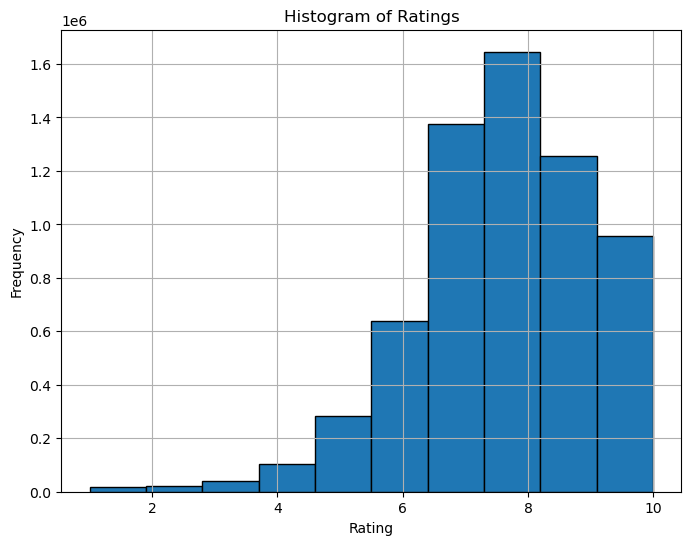

In [25]:
#Menampilkan Grafik Rating
# Data
ratings = ratingfull_df['rating']

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(ratings, bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')
plt.grid(True)
plt.show()

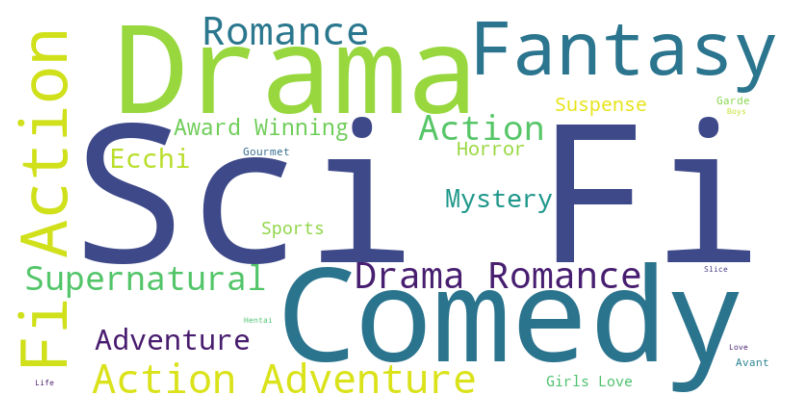

In [26]:
# Menggabungkan semua rating menjadi satu string untuk wordcloud
text = ' '.join(anime_df['Genres'].astype(str).tolist())

# Membuat wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


            index      MAL_ID       Score          Rank   Popularity  \
count  177.000000  177.000000  177.000000    176.000000   177.000000   
mean    88.000000  107.457627    7.361469   2979.017045  2628.553672   
std     51.239633   54.813316    0.656715   2442.391195  1918.575578   
min      0.000000    1.000000    4.810000     23.000000     8.000000   
25%     44.000000   63.000000    6.920000   1068.750000  1271.000000   
50%     88.000000  109.000000    7.370000   2383.500000  2135.000000   
75%    132.000000  154.000000    7.760000   4507.750000  3734.000000   
max    176.000000  199.000000    8.880000  12864.000000  9810.000000   

            Members      Favorites  
count  1.770000e+02     177.000000  
mean   2.161293e+05    5280.966102  
std    4.023099e+05   20957.559966  
min    3.274000e+03       3.000000  
25%    3.614000e+04     133.000000  
50%    9.643500e+04     622.000000  
75%    1.894230e+05    1873.000000  
max    2.859218e+06  221978.000000  


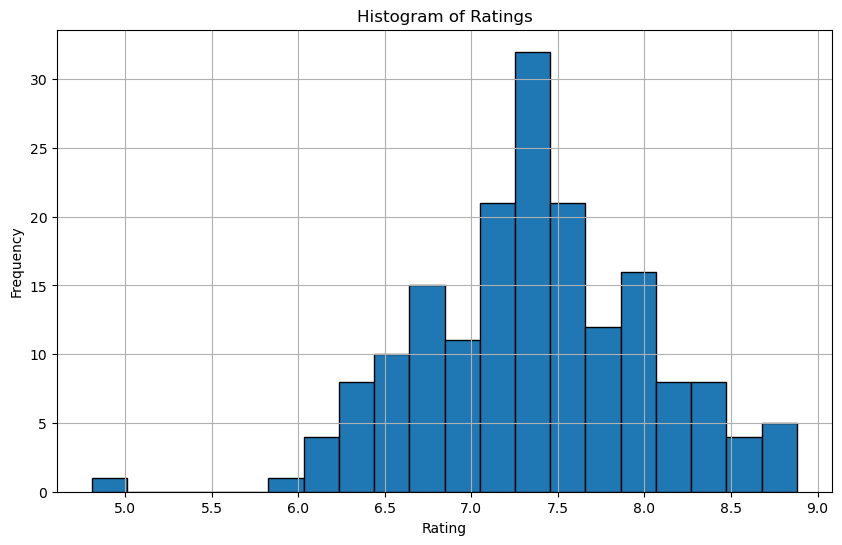

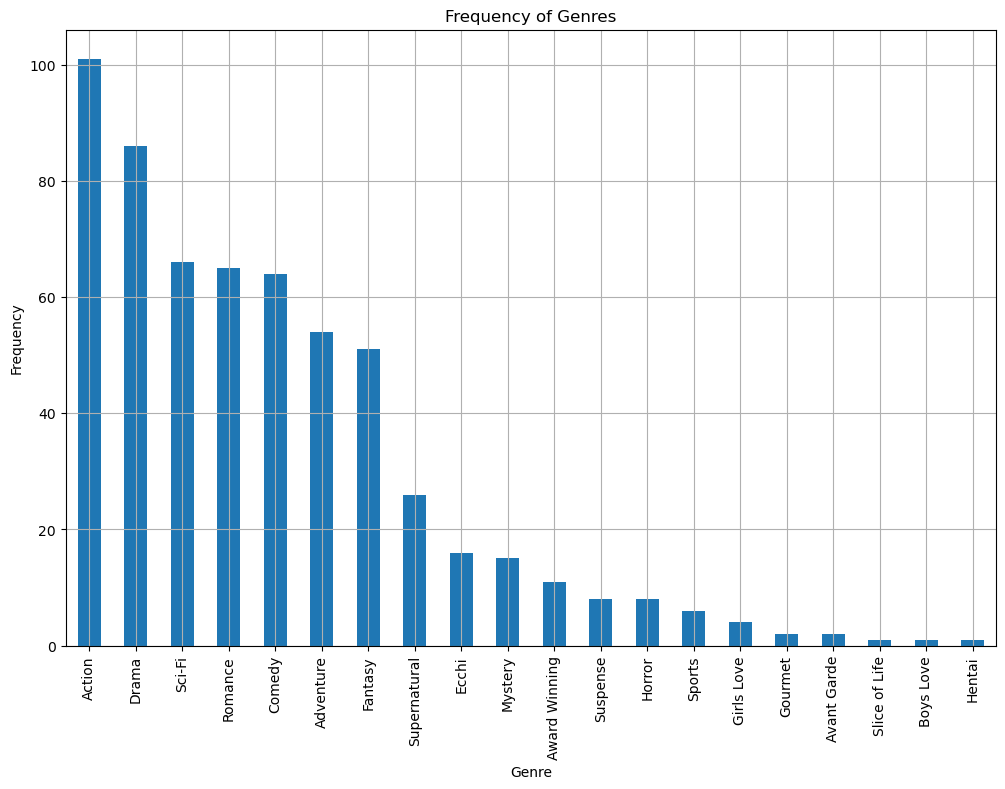

In [27]:
# Exploratory Data Analysis (EDA)
# Menghitung statistik deskriptif dasar
print(anime_df.describe())

# Menghitung distribusi rating
ratings = anime_df['Score'].dropna()

# Plot histogram untuk distribusi rating
plt.figure(figsize=(10, 6))
plt.hist(ratings, bins=20, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')
plt.grid(True)
plt.show()

# Memproses dan menghitung frekuensi genre
all_genres = anime_df['Genres'].dropna().str.split(', ')
all_genres = [genre for sublist in all_genres for genre in sublist]
genres_series = pd.Series(all_genres)

# Plot bar chart untuk frekuensi genre
plt.figure(figsize=(12, 8))
genres_series.value_counts().plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Frequency of Genres')
plt.grid(True)
plt.show()


## Hybrid Filtering

In [28]:
# Membuat indeks pemetaan
id_map = anime_df[['MAL_ID']]
id_map['id'] = list(range(1,anime_df.shape[0]+1,1))
id_map = id_map.merge(anime_df[['MAL_ID', 'Name']], on='MAL_ID').set_index('Name')

In [29]:
indices_map = id_map.set_index('id')

In [30]:
def hybrid_recommendations(user_id, anime_id, title, k=10):
    # Bagian rekomendasi berbasis konten (seperti yang sudah ada sebelumnya)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    anime_indices = [i[0] for i in sim_scores]
    
    anime_lst = anime_df.iloc[anime_indices][['MAL_ID', 'Name', 'Members', 'Score', 'Genres']]
    favorite_count = anime_lst[anime_lst['Members'].notnull()]['Members'].astype('int')
    score_avg = anime_lst[anime_lst['Score'].notnull()]['Score'].astype('float')
    C = score_avg.mean()
    m = favorite_count.quantile(0.60)
    qualified = anime_lst[(anime_lst['Members'] >= m) & (anime_lst['Members'].notnull()) & (anime_lst['Score'].notnull())]
    qualified['Members'] = qualified['Members'].astype('int')
    qualified['Score'] = qualified['Score'].astype('float')
    
    def weighted_rating(x):
        v = x['Members']
        R = x['Score']
        return (v / (v + m) * R) + (m / (m + v) * C)
    
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(30)
    qualified['id'] = list(range(1, qualified.shape[0] + 1, 1))
    qualified['est_svd'] = qualified['id'].apply(lambda x: svd.predict(user_id, indices_map.loc[x]['MAL_ID']).est)
    qualified['est_knn'] = qualified['id'].apply(lambda x: knn.predict(user_id, indices_map.loc[x]['MAL_ID']).est)
    
    # Kombinasikan estimasi SVD dan KNN
    qualified['est'] = qualified.apply(lambda x: (x['est_svd'] + x['est_knn']) / 2, axis=1)
    qualified = qualified.sort_values('est', ascending=False)
    
    result = qualified[['MAL_ID', 'Name', 'Genres', 'Score', 'Members', 'wr', 'est']]
    
    # Menampilkan grafik hasil rekomendasi
    plt.figure(figsize=(8, 6))
    plt.barh(result['Name'], result['wr'], color='red')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Anime')
    plt.title('Top 10 Hybrid Anime Recommendations')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()
    
    return result


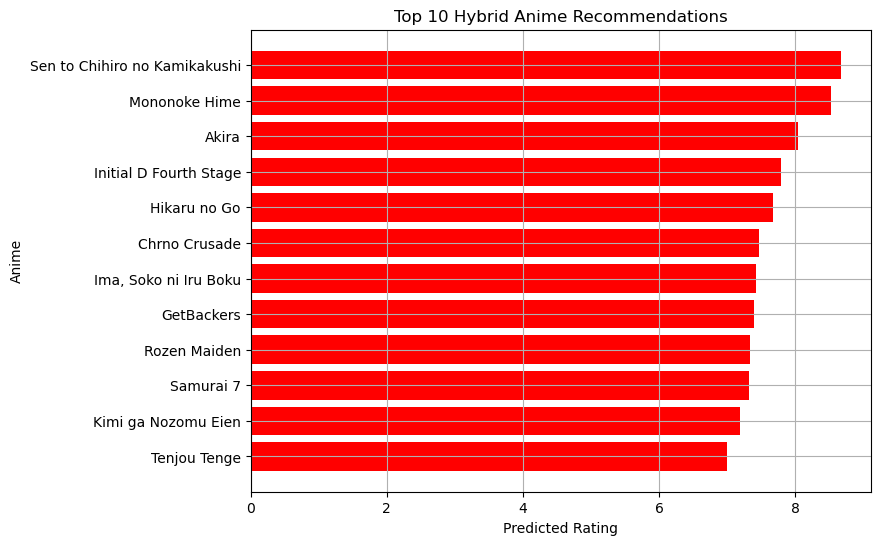

,MAL_ID,Name,Genres,Score,Members,wr,est
176,199,Sen to Chihiro no Kamikakushi,"Adventure, Award Winning, Supernatural",8.77,1859771,8.674551,5.0
142,164,Mononoke Hime,"Action, Adventure, Award Winning, Fantasy",8.66,1259876,8.532757,5.0
28,47,Akira,"Action, Adventure, Horror, Sci-Fi, Supernatural",8.16,856037,8.042244,5.0
8,18,Initial D Fourth Stage,"Action, Drama",8.17,189423,7.795725,5.0
114,135,Hikaru no Go,"Comedy, Drama, Supernatural",8.07,139364,7.670390,5.0
41,60,Chrno Crusade,"Action, Romance, Supernatural",7.61,227469,7.471333,5.0
138,160,"Ima, Soko ni Iru Boku","Adventure, Drama, Fantasy, Sci-Fi",7.59,146213,7.418286,5.0
111,132,GetBackers,"Action, Mystery, Supernatural",7.57,123095,7.391972,5.0
45,64,Rozen Maiden,"Action, Comedy, Drama, Fantasy",7.41,206112,7.336391,5.0
144,166,Samurai 7,"Action, Sci-Fi",7.43,132161,7.325344,5.0


In [31]:
user_id = 1
anime_id = 356
title = "Naruto"
recommendations = hybrid_recommendations(user_id, anime_id, title)
recommendations.head(10)

In [32]:
def performance_recommendations(user_id, anime_id, title, k=10):
    # Bagian rekomendasi berbasis konten (seperti yang sudah ada sebelumnya)
    try:
        idx = indices[title]
    except KeyError:
        print(f"Title '{title}' not found in indices.")
        return
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]    
    anime_indices = [i[0] for i in sim_scores]
            
    anime_lst = anime_df.iloc[anime_indices][['MAL_ID', 'Name', 'Members', 'Score', 'Genres']]
    favorite_count = anime_lst[anime_lst['Members'].notnull()]['Members'].astype('int')
    score_avg = anime_lst[anime_lst['Score'].notnull()]['Score'].astype('float')
    C = score_avg.mean()
    m = favorite_count.quantile(0.60)
    qualified = anime_lst[(anime_lst['Members'] >= m) & (anime_lst['Members'].notnull()) & (anime_lst['Score'].notnull())]    
    qualified['Members'] = qualified['Members'].astype('int')
    qualified['Score'] = qualified['Score'].astype('float')
    
    def weighted_rating(x):
        v = x['Members']
        R = x['Score']
        return (v / (v + m) * R) + (m / (m + v) * C)
    
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(30)    
    qualified['id'] = list(range(1, qualified.shape[0] + 1, 1))

    # Get predictions from both models
    try:
        qualified['est_svd'] = qualified['id'].apply(lambda x: svd.predict(user_id, indices_map.loc[x, 'MAL_ID']).est)
        qualified['est_knn'] = qualified['id'].apply(lambda x: knn.predict(user_id, indices_map.loc[x, 'MAL_ID']).est)
    except KeyError as e:
        print(f"KeyError during prediction: {e}")
        return

    # Content-based prediction (weighted rating)
    qualified['est_content'] = qualified['wr']

    # Combine the predictions (simple average)
    qualified['est_hybrid'] = (qualified['est_svd'] + qualified['est_knn'] + qualified['est_content']) / 3
    qualified = qualified.sort_values('est_hybrid', ascending=False)
    result = qualified[['MAL_ID', 'Name', 'Genres', 'Score', 'Members', 'wr', 'est_svd', 'est_knn', 'est_content', 'est_hybrid']]
    
    # Calculate RMSE for each method and the combined result
    actual_scores = qualified['Score'].values
    predicted_scores_svd = qualified['est_svd'].values
    predicted_scores_knn = qualified['est_knn'].values
    predicted_scores_content = qualified['est_content'].values
    predicted_scores_hybrid = qualified['est_hybrid'].values
    
    rmse_svd = np.sqrt(mean_squared_error(actual_scores, predicted_scores_svd))
    rmse_knn = np.sqrt(mean_squared_error(actual_scores, predicted_scores_knn))
    rmse_content = np.sqrt(mean_squared_error(actual_scores, predicted_scores_content))
    rmse_hybrid = np.sqrt(mean_squared_error(actual_scores, predicted_scores_hybrid))
    
    print(f'RMSE SVD: {rmse_svd}')
    print(f'RMSE KNN: {rmse_knn}')
    print(f'RMSE Content-based: {rmse_content}')
    print(f'RMSE Hybrid: {rmse_hybrid}')
    
    # Plot results
    plt.figure(figsize=(12, 8))
    ranks = range(1, len(actual_scores) + 1)
    plt.plot(ranks, actual_scores, marker='o', label='Actual Scores', linestyle='--')
    plt.plot(ranks, predicted_scores_svd, marker='x', label='Predicted Scores SVD')
    plt.plot(ranks, predicted_scores_knn, marker='.', label='Predicted Scores KNN')
    plt.plot(ranks, predicted_scores_content, marker='^', label='Predicted Scores Content-based')
    plt.plot(ranks, predicted_scores_hybrid, marker='d', label='Predicted Scores Hybrid')
    plt.title('Actual vs Predicted Scores')
    plt.xlabel('Rank')
    plt.ylabel('Scores')
    plt.legend()
    plt.grid(True)
    plt.show()


    
    return result.head(k)


RMSE SVD: 2.8396185189798526
RMSE KNN: 2.8396185189798526
RMSE Content-based: 0.17841184677288544
RMSE Hybrid: 1.9226028837407312


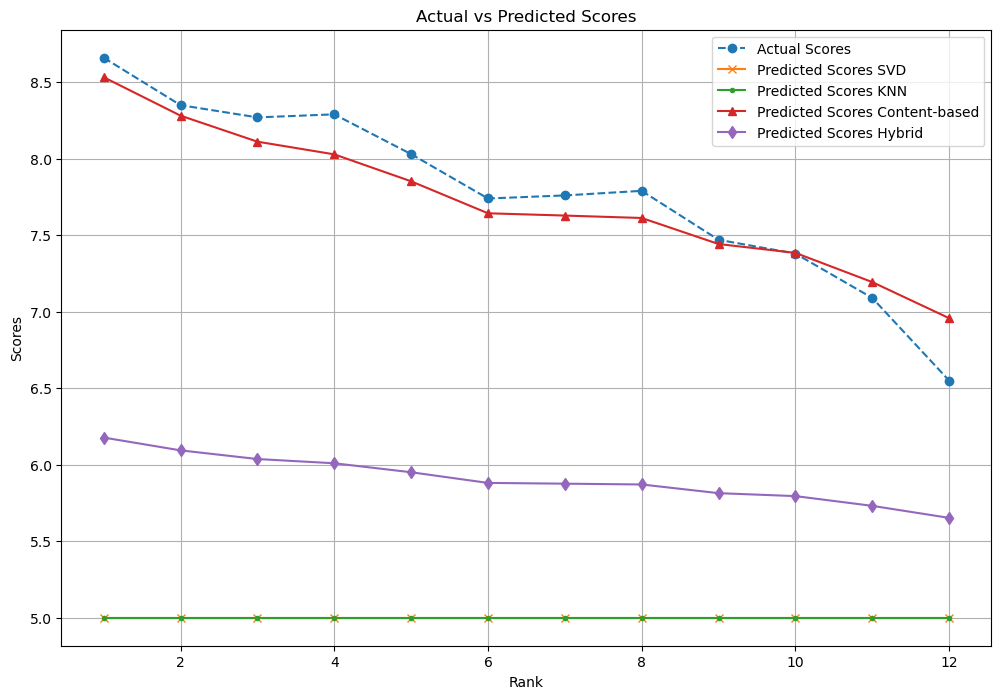

,MAL_ID,Name,Genres,Score,Members,wr,est_svd,est_knn,est_content,est_hybrid
142,164,Mononoke Hime,"Action, Adventure, Award Winning, Fantasy",8.66,1259876,8.532606,5,5,8.532606,6.177535
20,30,Shinseiki Evangelion,"Action, Avant Garde, Award Winning, Drama, Sci...",8.35,1823690,8.281355,5,5,8.281355,6.093785
24,43,Koukaku Kidoutai,"Action, Award Winning, Mystery, Sci-Fi, Suspense",8.27,638638,8.111385,5,5,8.111385,6.037128
38,57,Beck,"Comedy, Drama",8.29,342691,8.028429,5,5,8.028429,6.009476
47,66,Azumanga Daiou The Animation,Comedy,8.03,365128,7.852301,5,5,7.852301,5.950767


In [33]:
title = "Akira"
recommendations = performance_recommendations(user_id, anime_id, title, k=5)
recommendations.head(10)